## Z_N HC code

In [251]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Dict, Any, Set, FrozenSet, Iterable, Tuple
import math
import random
import networkx as nx
import sympy as sym

import os
import galois

Lets outline how to represent everything:

* Coordinate system: (a+jb) is down b steps and right a steps


* Logicals: can be represented as 2*dataqubits vector (Xs on all data qubits|Z on all data qubits) this lives in the final time slice

* Error string: this can be pushed through to the final time step so we can check commutation with the logical:
1. use decoder to get errors on each data qubit. 
2. X error on qubit n in the final round will be sum of all the X errors on n throughout time. Note these only correspond to errors after blue plaquette inferences.

### Details of what we need for this

In [252]:
EDGES_AROUND_HEX: List[Tuple[complex, complex]] = [
    (-1 - 1j, +1 - 1j),
    (+1 - 1j, +1),
    (+1, +1 + 1j),
    (+1 + 1j, -1 + 1j),
    (-1 + 1j, -1),
    (-1, -1 - 1j),
]


def torus(c: complex, distance: int) -> complex:
    """Apply toroidal topology to a point on the lattice."""
    r = c.real % (distance * 4)
    i = c.imag % (distance * 6)
    return r + i*1j

def sorted_complex(xs: Iterable[complex]) -> List[complex]:
    """Sort a list of complex numbers."""
    return sorted(xs, key=lambda v: (v.real, v.imag))

def int_to_pauli(i: int) -> str:
    """Convert an integer to a Pauli operator."""
    pauli_dict = {0: "X", 1: "Y", 2: "Z"}
    if i not in pauli_dict:
        raise ValueError('Integer must be 0, 1, or 2')
    return pauli_dict[i]

######### Plaquette functions    

def initialize_hex_centers(distance: int) -> Dict[complex, int]:
    """Initialize the hex centers on the lattice."""
    hex_centers = {}
    for row in range(3 * distance):
        for col in range(2 * distance):
            center = row * 2j + 2 * col - 1j * (col % 2)
            category = (-row - col % 2) % 3
            hex_centers[torus(center, distance=distance)] = category
    return hex_centers

def categorize_hexes(hex_centers: Dict[complex, int]) -> Tuple[List[complex], List[complex], List[complex]]:
    """Categorize hexes into red, green, and blue."""
    red_hexes = [h for h, category in hex_centers.items() if category == 0]
    green_hexes = [h for h, category in hex_centers.items() if category == 1]
    blue_hexes = [h for h, category in hex_centers.items() if category == 2]
    return red_hexes, green_hexes, blue_hexes

def get_rgb_hexes(distance: int) -> Tuple[List[complex], List[complex], List[complex]]:
    """Get the red, green, and blue hexes."""
    hex_centers = initialize_hex_centers(distance=distance)
    red_hexes, green_hexes, blue_hexes = categorize_hexes(hex_centers=hex_centers)
    return red_hexes, green_hexes, blue_hexes

##### qubit functions
def qubits_in_plaquettes(d):
    QUBITS_AROUND_HEX = [
        (-1 - 1j),
        (+1 - 1j),
        (+1),
        (+1 + 1j),
        (-1 + 1j),
        (-1)
    ]
    hexes = initialize_hex_centers(d)
    qubit_dictionary = {}
    for hex in hexes:
        qubit_coordinates = set()
        for qubit in QUBITS_AROUND_HEX:
            q = hex + qubit
            qubit_coordinates.add(torus(q,d))

        qubit_dictionary[hex] = qubit_coordinates

    return qubit_dictionary

def qubits(d):
    qubits_set = set()
    for p in get_rgb_hexes(d)[0]:
        for q in qubits_in_plaquettes(d)[p]:
            qubits_set.add(q)

    return sorted_complex(list(qubits_set))

def qubits_to_plaq(d): # returns dic D: D[q] = [pos R, pos G, pos B]
    qubits_= {}
    qubits_in_plaq= qubits_in_plaquettes(d)
    r,g,b = get_rgb_hexes(d)
    for qubit in qubits(d):
        qubits_in_plaq[qubit] = []
        
        for c in [r,g,b]:
            for plaq in c:
                if overlap(qubits_in_plaq[plaq], {qubit}):
                    qubits_in_plaq[qubit].append(plaq)
    return qubits_in_plaq


##### edge functions
EDGES_AROUND_HEX: List[Tuple[complex, complex]] = [
    (-1 - 1j, +1 - 1j), #top T
    (+1 - 1j, +1), #top right TR
    (+1, +1 + 1j), #bottom right BR
    (+1 + 1j, -1 + 1j), # bottom B
    (-1 + 1j, -1), #bottom left BL
    (-1, -1 - 1j), # top left TL
]

edge_dictionary ={}
for i, edge in enumerate(['T', 'TR', 'BR', 'B', 'BL', 'TL']):
    edge_dictionary[edge] = EDGES_AROUND_HEX[i]

# use fig 1 of https://arxiv.org/pdf/2108.10457.pdf
# left create dictionary between -> (edge, color)

def get_rgb_edges(d):
    r,g,b = get_rgb_hexes(d)
    r_edges, g_edges, b_edges = [[],[],[]]
    edge_translation = lambda h,edge: (torus(h+edge[0], d), torus(h+edge[1],d))

    # edge = {(qubit_0, qubit_1), pauli_type, (error_0, error_1), color}
    for plaq in r:
        b_edges.append({'qubits':edge_translation(plaq, edge_dictionary['T']),'type': 'Z', 'error type': ('X', 'Y'), 'color': 'b'})
        b_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BR']),'type': 'X', 'error type': ('Y', 'Z'), 'color': 'b'})
        b_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BL']),'type': 'Y', 'error type': ('Z', 'X'), 'color': 'b'})

    for plaq in g:
        r_edges.append({'qubits':edge_translation(plaq, edge_dictionary['T']),'type': 'Z', 'error type': ('X', 'Y'), 'color': 'r'})
        r_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BR']),'type': 'X', 'error type': ('Y', 'Z'), 'color': 'r'})
        r_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BL']),'type': 'Y', 'error type': ('Z', 'X'), 'color': 'r'})

    for plaq in b:
        g_edges.append({'qubits':edge_translation(plaq, edge_dictionary['T']),'type': 'Z', 'error type': ('X', 'Y'), 'color': 'g'})
        g_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BR']),'type': 'X', 'error type': ('Y', 'Z'),'color': 'g'})
        g_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BL']),'type': 'Y', 'error type': ('Z', 'X'),'color': 'g'})
        

    return r_edges, g_edges, b_edges

def overlap(qubits1: set, qubits2: set): #checks if two lists of qubits around plaquettes overlap
    share_qubit = False
    if not qubits1.isdisjoint(qubits2):
        share_qubit=True
    return share_qubit

def tuple_diff(p:Tuple, e:Tuple):
    x = (p[0] - e[0]) 
    y = (p[1] - e[1])
    t = (p[2]-p[2])

    return (x,y,t)

def graph_inverse(dic, property, property_val):
    key = 0
    for keys in dic:
        if dic[keys][property] == property_val:
            key = keys
    return key


def comm_dict(q):
    dic= {}
    dic['X', 'Y'] = 1
    dic['X', 'Z'] = q-1
    dic['Y','X'] = q-1
    dic['Y','Z'] = 1
    dic['Z','Y'] = q-1
    dic['Z', 'X'] = 1

    return dic




## Now that we have all these useful functions, lets define a class

In [281]:
class HC_code():
    def __init__(self, distance, depth, qubit_dim):
        self.distance = distance
        self.q = qubit_dim
        self.depth = depth

        # Now lets get a bunches of data structures relating things eg (plaq->qubits, edges->qubits etc)

        # r,g and b plaquette coordinates
        self.r_xy, self.g_xy, self.b_xy = get_rgb_hexes(self.distance)
        self.comm_relations = comm_dict(self.q) #dictionary for commutation realtions

        # qubit coordinates
        qubits_set = set()
        for p in self.r_xy:
            for q in qubits_in_plaquettes(self.distance)[p]:
                qubits_set.add(q)

        self.qubits = sorted_complex(list(qubits_set)) # list of all data qubit
        
        #dictionary plaq coord->qubit around plaquette coord
        self.plaq_to_qubit = qubits_in_plaquettes(self.distance)

        #dictionary qubit coord -> surrounding plaq [R,G,B] coord
        self.qubit_to_plaq = qubits_to_plaq(self.distance)
        # need function for all qubits

        #r,g and b edges
        self.r_edges, self.g_edges, self.b_edges = get_rgb_edges(self.distance)
    
    def make_tanner_graph(self):
        T = nx.Graph()

        self.R_nodes,self.G_nodes,self.B_nodes = [[],[],[]]
        self.stabilizer_nodes = []

        # add plaq nodes
        plaq_node_counter = 0
        for t in range(self.depth):
            for plaq_node in self.r_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*t), color = 'r', xy = plaq_node) # add node
                self.R_nodes.append(plaq_node_counter) #store in color list
                self.stabilizer_nodes.append(plaq_node_counter) #store in all plaq list
                plaq_node_counter+=1


            for plaq_node in self.g_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*t+1), color = 'g', xy = plaq_node)
                self.G_nodes.append(plaq_node_counter)
                self.stabilizer_nodes.append(plaq_node_counter)
                plaq_node_counter+=1


            for plaq_node in self.b_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*t+2), color = 'b', xy = plaq_node)
                self.B_nodes.append(plaq_node_counter)
                self.stabilizer_nodes.append(plaq_node_counter)
                plaq_node_counter+=1

        ##add one more layer of red
        for plaq_node in self.r_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*self.depth), color = 'rx', xy = plaq_node) # add node
                self.R_nodes.append(plaq_node_counter) #store in color list
                self.stabilizer_nodes.append(plaq_node_counter) #store in all plaq list
                plaq_node_counter+=1

################################################
        #### add data nodes
        data_node_counter,t = [-1, 0] #data nodes < 0
        self.data_nodes = []
        
        while t < 3*self.depth-3: # generate all but final layer of data qubits
            for c_edges in [self.b_edges,self.r_edges,self.g_edges]:
                for edge in c_edges:
                    qubits_pos = edge['qubits'] #(qubit0, qubit1)
                    error_type = edge['error type'] #('sigma0', 'sigma1')
                    color_type = edge['color']
                    edge_type = edge['type'] # need this to work out commutation relation for parity check matrix

                    for i in [0,1]:
                        T.add_node(data_node_counter, pos = (qubits_pos[i].real, qubits_pos[i].imag, t+1/2), error = error_type[i], xy = qubits_pos[i], color = color_type, edge_before = edge_type)
                        self.data_nodes.append(data_node_counter)
                        data_node_counter-=1
                t+=1
        
        for c_edges in [self.b_edges,self.r_edges]: #last layers doesnt have data qubits for penultimate blue plaq layers or final red plaq layer
            for edge in c_edges:
                qubits_pos = edge['qubits'] #(qubit0, qubit1)
                error_type = edge['error type'] #('sigma0', 'sigma1')
                color_type = edge['color'] 
                edge_type = edge['type'] # need this to work out commutation relation for parity check matrix

                for i in [0,1]:
                    T.add_node(data_node_counter, pos = (qubits_pos[i].real, qubits_pos[i].imag, t+1/2), error = error_type[i], xy = qubits_pos[i], color = color_type, edge_before = edge_type)
                    self.data_nodes.append(data_node_counter)
                    data_node_counter-=1
            t+=1  

################################################
        # now add edges
        for data_node in self.data_nodes:
            t, xy_data, color = [T.nodes[data_node]['pos'][2], T.nodes[data_node]['xy'], T.nodes[data_node]['color']]
            r_coord, g_coord, b_coord = self.qubit_to_plaq[xy_data]

            parity_entry = self.comm_relations[T.nodes[data_node]['error'],T.nodes[data_node]['edge_before']]
            #RB 
            if color == 'b':
                r_node = graph_inverse(T.nodes, 'pos', (r_coord.real, r_coord.imag, t-1/2))
                T.add_edge(r_node, data_node, label = T.nodes[data_node]['error'], parity = parity_entry)

                b_node = graph_inverse(T.nodes, 'pos', (b_coord.real, b_coord.imag, t+1+1/2))
                T.add_edge(b_node, data_node, label = T.nodes[data_node]['error'], parity = -parity_entry % self.q) # might have to fix this when we use galois
            
            if color == 'g':
                b_node = graph_inverse(T.nodes, 'pos', (b_coord.real, b_coord.imag, t-1/2))
                T.add_edge(b_node, data_node, label = T.nodes[data_node]['error'], parity = parity_entry)

                if t<3*self.depth-1:

                    g_node = graph_inverse(T.nodes, 'pos', (g_coord.real, g_coord.imag, t+1+1/2))
                    T.add_edge(g_node, data_node, label = T.nodes[data_node]['error'], parity = -parity_entry % self.q)

            if color == 'r':
                g_node = graph_inverse(T.nodes, 'pos', (g_coord.real, g_coord.imag, t-1/2))
                T.add_edge(g_node, data_node, label = T.nodes[data_node]['error'], parity = parity_entry)

                r_node = graph_inverse(T.nodes, 'pos', (r_coord.real, r_coord.imag, t+1+1/2))
                T.add_edge(r_node, data_node, label = T.nodes[data_node]['error'], parity = -parity_entry % self.q)

        self.T = T

        ### make parity check matrix
    def make_H(self):
        self.H = np.zeros((len(self.R_nodes+self.G_nodes+self.B_nodes), len(self.data_nodes)))
        for u,v in self.T.edges():
            self.H[u,-v-1]=self.T.edges[(u,v)]['parity']



        ### We will need dictionaries relating data_nodes corresponding to the same physical qubit
        self.qubits_over_time = {} # dic[node at t0] = [(node at t = n, sigma at t= n)] where all the nodes are on same physical site
        for node in self.data_nodes[0:len(self.qubits)]:
            self.qubits_over_time[node] = []
            xy = self.T.nodes[node]['xy']

            for later_nodes in self.data_nodes:
                if self.T.nodes[later_nodes]['xy'] == xy:
                    self.qubits_over_time[node].append((later_nodes, self.T.nodes[later_nodes]['error']))

    def make_error(self): # need to fix so errors appear in initial and final rounds

        self.E = np.zeros(len(self.data_nodes))

        error = lambda : {'X': np.random.randint(0,2), 'Y': np.random.randint(0,2), 'Z': np.random.randint(0,2)} # change this to more general error model
        

        for initial_node in self.qubits_over_time:
            temp_dic = self.qubits_over_time[initial_node]

            for t in range(1,3*self.depth-2): ######### fix this so we have errors in first and last layer. As is its only 2nd through n-1 th
                sigma_before, sigma_now, sigma_after = [temp_dic[t-1][1], temp_dic[t][1], temp_dic[t+1][1]] 
                e = error()
                
                self.E[-temp_dic[t][0]-1] += e[sigma_before] +e[sigma_after] #mod q
                self.E[-temp_dic[t+1][0]-1] += e[sigma_now] +e[sigma_after] #mod q

                self.E = self.E % self.q



    
    def logicals(self): # we always consider logical just after blue round (so red plaq just updated)
        L1v = np.zeros((2, len(self.qubits), len(self.qubits))) #L1v[0] = x part and L1v[1] = z part      
        L1h = np.zeros((2, len(self.qubits), len(self.qubits)))
        # use




Now let's think about how to ecode the errors:

* One problem is that the odering of the data_nodes is not the same as the snaking pattern of self.qubits

* For every data_node we will have a three vector error np.array([X_error, Z_error, Y_error]): encode in dictionary 

* define Error vector = np.arrray(3t*qubits)
1. entry i corresponds to 

## Lets test the code above

In [300]:
code = HC_code(3,2,5)
code.make_tanner_graph()
code.make_H()
code.make_error()

In [301]:
((code.H @ code.E)%5).sum()

215.0

In [284]:
Error = np.zeros(len(code.data_nodes))
error = lambda : {'X': np.random.randint(0,2), 'Y': np.random.randint(0,2), 'Z': np.random.randint(0,2)}

nodes = code.qubits_over_time[-2]

In [285]:
q12 = code.r_edges[0]['qubits'] 
node0 = graph_inverse(code.T.nodes, 'pos', (q12[0].real, q12[0].imag, 1/2))
node1 = graph_inverse(code.T.nodes, 'pos', (q12[1].real, q12[1].imag, 1/2))

In [286]:
q12

((1+0j), (3+0j))

In [287]:
code.qubits_over_time[node0]


[(-3, 'Y'), (-109, 'X'), (-221, 'Z'), (-327, 'Y'), (-433, 'X')]

In [288]:
code.qubits_over_time[node1]

[(-12, 'X'), (-110, 'Y'), (-220, 'Z'), (-336, 'X'), (-434, 'Y')]

In [289]:
nodes = code.qubits_over_time[-2]


for n in range(1,len(nodes)-1):
    sigma_before, sigma_now, sigma_after = [nodes[n-1][1], nodes[n][1], nodes[n+1][1]] 
    e = error()
    Error[-nodes[n][0]-1] += e[sigma_before] +e[sigma_after] #mod q
    Error[-nodes[n+1][0]-1] += e[sigma_now] +e[sigma_after] #mod q



In [290]:
Error.sum()

9.0

In [291]:
Error[[-(-2)-1,-(-202)-1,-(-222)-1,-(-326)-1,-(-526)-1]]

array([0., 2., 3., 3., 1.])

In [292]:
site_list = []
site_t0 = code.T.nodes[-1]['xy']

for node in code.data_nodes:
    if site_t0 == code.T.nodes[node]['xy']:
        site_list.append(node)
site_list

[-1, -203, -231, -325, -527]

<Figure size 2000x1500 with 0 Axes>

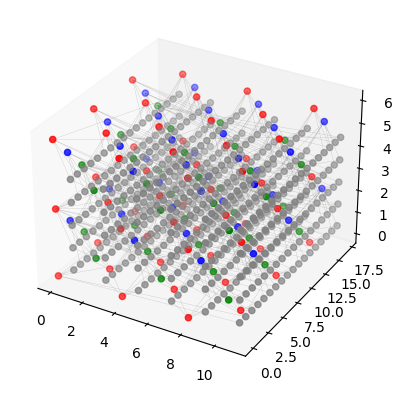

In [293]:
plt.figure(figsize=(20,15))
    
pl=nx.get_node_attributes(code.T,'pos')
lbls_nodes = nx.get_node_attributes(code.T, 'label')


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


data_nodes = np.array([pl[node] for node in sorted(code.T) if node < 0])
check_nodes_R = np.array([pl[node] for node in sorted(code.R_nodes) if node >-1])
check_nodes_G = np.array([pl[node] for node in sorted(code.G_nodes) if node >-1])
check_nodes_B = np.array([pl[node] for node in sorted(code.B_nodes) if node >-1])
ax.scatter(*check_nodes_R.T, color = 'red')
ax.scatter(*check_nodes_G.T, color = 'green')
ax.scatter(*check_nodes_B.T, color = 'blue')
ax.scatter(*data_nodes.T, color = 'grey')
ax.grid(False)

edge_xyz = np.array([(code.T.nodes[u]['pos'], code.T.nodes[v]['pos'])for u, v in code.T.edges()])

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray", linewidth = .1)

plt.show()

In [294]:
code.H

array([[4., 1., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.]])